# Flowers 102 Dataset Classification

Pre-Processing

In [105]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=ToTensor()
)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                          shuffle=True, num_workers=0)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=ToTensor()
)

testloader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=False, num_workers=0)

val_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform=ToTensor()
)

valloader = torch.utils.data.DataLoader(val_data, batch_size=32,
                                          shuffle=False, num_workers=0)

# Display images randomly

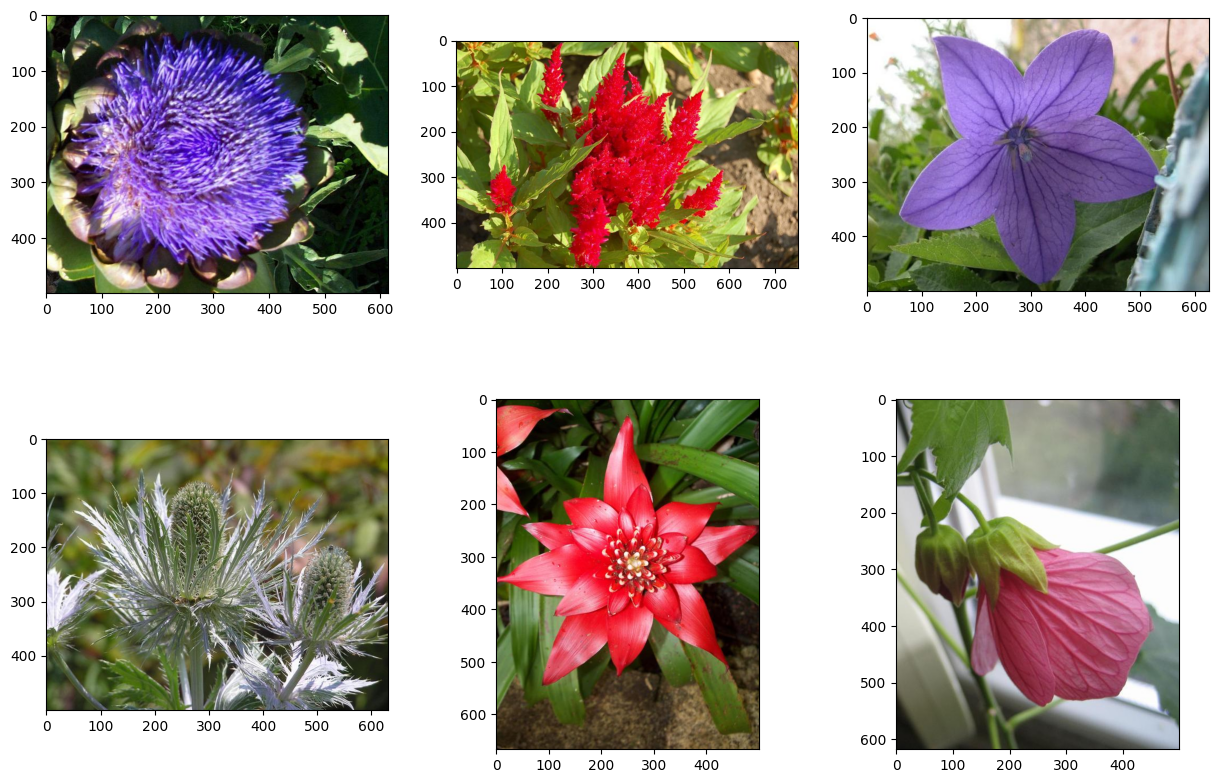

In [106]:
figure = plt.figure(figsize=(15, 10))
cols, rows = 3, 2

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    img = img.permute(1, 2, 0)
    ax = figure.add_subplot(rows, cols, i)
    ax.axis("on")
    ax.imshow(img.squeeze(), cmap="Accent")
plt.show()